In [1]:
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

In [2]:
def plot_steps(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        iteration = data.iloc[runIdx]["iteration"]
        clusters = data.iloc[runIdx]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters))
        print("iteration: %s, clusters: %s" % (iteration, len(clusters)))
        for cIdx in range(0, len(clusters)):
            rgba_color = cm.gnuplot(norm(cIdx))
            pointsX = [point[0] for point in clusters[cIdx]["points"]]
            pointsY = [point[1] for point in clusters[cIdx]["points"]]
            ax.scatter(pointsX, pointsY, color=rgba_color)
            ax.scatter(clusters[cIdx]["centroid"][0], clusters[cIdx]["centroid"][1], color=rgba_color, marker="+")

        plt.show()

In [3]:
def plot(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        clusters_step1 = data.iloc[runIdx]["steps"][0]["clusters"]
        clusters_step2 = data.iloc[runIdx]["steps"][1]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters_step1))
        for cIdx in range(0, len(clusters_step1)):
            rgba_color = cm.gnuplot(norm(cIdx))
            ax.plot(clusters_step1[cIdx]["syntheticCenter"], "--", color=rgba_color, label="cluster %s" % cIdx)
            ax.plot(clusters_step2[cIdx]["syntheticCenter"], color=rgba_color, label="cluster %s - rescheduled" % cIdx)
            print(clusters_step2[cIdx]["metric"])
        ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)

        ax.set(xlabel='Hours', ylabel='Power (kW)',title='')
        plt.show()

In [4]:
def plot_aggm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. agg m"], "--", color=rgba_color, label="s1. agg m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. agg m"], color=rgba_color, label="s2. agg m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_maxm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. max m"], "--", color=rgba_color, label="s1. max m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. max m"], color=rgba_color, label="s2. max m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Max. Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_peak(summary, file_name=None):
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. peak"], "--", color=rgba_color, label="s1. peak")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. peak"], color=rgba_color, label="s2. peak")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Peak power (kW)',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig

# PAR Aggregate

In [23]:
summaryBatch_global = pd.read_json("./files/scheduler_tests/scheduler_test_no_optimization/summaryBatch.json")
#summaryBatch_global = summaryBatch_global[["k","clusters","s1. agg m","s1. max m","s1. peak","s2. agg m","s2. max m","s2. peak","total m"]]
#batch_global = pd.read_json("./files/batch.json")

exp1_k = 6
exp1_sample_size_min = 0.5
exp1_sample_size_max = 1.0
exp1_nsteps = 2


def sample_size_range(sample_size_min, sample_size_max):
    return (x/10 for x in range(int(sample_size_min * 10), int((sample_size_max * 10) + 1)))

In [24]:
def crossfold_as_df(k, data):
    index_list = []
    step_list = []

    for i in range(0 , len(data)):
        register = data.iloc[i]

        crossfold = json_normalize(register["crossfold"])
        splits = crossfold["splits"].values[0]
        steps = data.iloc[i]["step"]
        for j in range(0, splits):
            step = json_normalize(steps[j])
            for ki in range(1, k+1):
                index_list.append((float("{0:.2f}".format(crossfold["sampleSize"].values[0])), j, ki))
                step_list.append(step.iloc[ki-1])


    json_normalize(data.iloc[0]["crossfold"])
    json_normalize(data.iloc[0]["step"][0])

    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "split", "k"])
    return pd.DataFrame(step_list, index=index)
exp1_treated = crossfold_as_df(exp1_k, summaryBatch_global)
exp1_treated

k  s1. peak  s1. agg m  s1. max m  s1. total m  \
sampleSize split k                                                   
0.5        0     1  1    619750   2.169740   2.169740     2.169740   
                 2  2    330816   1.006874   2.281184     2.169740   
                 3  3    253159   1.035564   2.730141     2.169740   
                 4  4    204811   1.066325   2.847403     2.169740   
                 5  5    188281   1.088387   3.305380     2.169740   
...                ..       ...        ...        ...          ...   
1.0        2     2  2    903737   1.000942   1.966364     1.965393   
                 3  3    641742   1.024117   2.102337     1.965393   
                 4  4    357181   1.012652   2.088760     1.965393   
                 5  5    428622   1.086278   2.356817     1.965393   
                 6  6    334657   1.078958   2.428621     1.965393   

                               clusters  s2. peak  s2. agg m  s2. max m  \
sampleSize split k                                                        
0.5        0     1                 [25]    619750   2.169740   2.169740   
                 2             [11, 14]    330816   1.006874   2.281184   
                 3           [7, 11, 7]    253159   1.121341   2.730141   
                 4         [9, 7, 6, 3]    204811   1.067910   2.838229   
                 5      [7, 6, 4, 4, 4]    193617   1.075154   3.305380   
...                                 ...       ...        ...        ...   
1.0        2     2             [39, 11]    876518   1.092336   2.295164   
                 3         [19, 16, 15]    630436   1.089939   2.269200   
                 4      [17, 15, 11, 7]    477350   1.403054   3.367139   
                 5   [10, 12, 9, 10, 9]    409766   1.074255   2.366329   
                 6  [8, 8, 7, 9, 8, 10]    493517   1.198649   2.939988   

                    s2. total m  
sampleSize split k               
0.5        0     1     2.169740  
                 2     2.169740  
                 3     2.169740  
                 4     2.169740  
                 5     2.169740  
...                         ...  
1.0        2     2     1.842278  
                 3     1.842278  
                 4     1.842278  
                 5     1.842278  
                 6     1.842278  

[108 rows x 10 columns]

In [7]:
k2 = 2
query = f"k == {k2} and sampleSize == {exp1_sample_size_min}"
exp1_treated.query(query)["s1. agg m"].mean()
exp1_treated.query(query)["s1. max m"].mean()
exp1_treated.query(query)["s1. peak"].std()

39549.584983073255

In [8]:
def get_statistics(k, nSteps, treated, sample_size_min, sample_size_max):
    index_list = []
    step_list = []

    for j in range(1, k+1):
        for ssize in sample_size_range(sample_size_min, sample_size_max):

            index_list.append((ssize, "mean", j))
            query = f"k == {j} and sampleSize == {ssize}"
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            data = {key: treated.query(query)[key].mean() for key in index}
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].mean(),
                    "s1. max m" : treated.query(query)["s1. max m"].mean(), 
                    "s1. peak" : treated.query(query)["s1. peak"].mean()/1000,
                   "s1. total m" : treated.query(query)["s1. total m"].mean()}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            if (nSteps >= 2):
                data.update({"s2. agg m" : treated.query(query)["s2. agg m"].mean(),
                    "s2. max m" : treated.query(query)["s2. max m"].mean(), 
                    "s2. peak" : treated.query(query)["s2. peak"].mean()/1000,
                            "s2. total m" : treated.query(query)["s2. total m"].mean()})
                index = index + ["s2. agg m","s2. max m","s2. peak", "s2. total m"]

            s = pd.Series(data,index=index) 
            step_list.append(s)
            #print(f"sampleSize = {ssize}, k = {j}")

            index_list.append((ssize, "stdv", j))
            query = f"k == {j} and sampleSize == {ssize}"
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].std(),
                    "s1. max m" : treated.query(query)["s1. max m"].std(), 
                    "s1. peak" : treated.query(query)["s1. peak"].std(),
                   "s1. total m" : treated.query(query)["s1. total m"].std()}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            if (nSteps >= 2):
                data.update({"s2. agg m" : treated.query(query)["s2. agg m"].std(),
                    "s2. max m" : treated.query(query)["s2. max m"].std(), 
                    "s2. peak" : treated.query(query)["s2. peak"].std(),
                            "s2. total m" : treated.query(query)["s2. total m"].std()})
                index = index + ["s2. agg m","s2. max m","s2. peak", "s2. total m"]

            s = pd.Series(data,index=index) 
            step_list.append(s)


    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "metric", "k"])
    return pd.DataFrame(step_list, index=index)
exp1_statistics = get_statistics(exp1_k,exp1_nsteps, exp1_treated, exp1_sample_size_min, exp1_sample_size_max)
exp1_statistics

s1. agg m  s1. max m      s1. peak  s1. total m  \
sampleSize metric k                                                    
0.5        mean   1   2.338253   2.338253    674.339333     2.338253   
           stdv   1   0.183118   0.183118  51017.191361     0.183118   
0.6        mean   1   1.912769   1.912769    760.811000     1.912769   
           stdv   1   0.076817   0.076817  69869.079706     0.076817   
0.7        mean   1   1.931600   1.931600    857.496667     1.931600   
...                        ...        ...           ...          ...   
0.8        stdv   6   0.023680   0.097333  43204.736974     0.097665   
0.9        mean   6   1.087781   2.576794    326.305667     1.950243   
           stdv   6   0.013512   0.091009  44902.525011     0.059265   
1.0        mean   6   1.065411   2.498804    358.435000     1.965393   
           stdv   6   0.017579   0.083609  48279.801025     0.000000   

                     s2. agg m  s2. max m      s2. peak   s2. total m  
sampleSize metric k                                                    
0.5        mean   1   2.168540   2.168540    625.197333  2.168540e+00  
           stdv   1   0.095586   0.095586  16847.948134  9.558649e-02  
0.6        mean   1   1.707300   1.707300    679.744333  1.707300e+00  
           stdv   1   0.099740   0.099740  77222.680246  9.973978e-02  
0.7        mean   1   1.856210   1.856210    822.851667  1.856210e+00  
...                        ...        ...           ...           ...  
0.8        stdv   6   0.233051   0.837087  62994.681191  5.057729e-03  
0.9        mean   6   1.353515   3.369284    389.936000  1.845874e+00  
           stdv   6   0.268117   0.704076  76190.364141  1.515226e-02  
1.0        mean   6   1.207207   2.946824    430.680333  1.842278e+00  
           stdv   6   0.110924   0.328550  87695.555015  2.719480e-16  

[72 rows x 8 columns]

In [9]:
def get_metrics(k, metric, metric_type, statistics, sample_size_min, sample_size_max):

    index_list = [sample_size_range(sample_size_min, sample_size_max)]
    cols = [x for x in range(1, k+1)]
    step_list = []

    for ssize in sample_size_range(sample_size_min, sample_size_max):
        query = f"sampleSize == {ssize} and metric == \"{metric_type}\" "
        dataAllK = statistics.query(query)[f"{metric}"]
        dictAllK = {}
        for j in range(1, k+1):
            d = dataAllK.reset_index().query(f"k == {j}")[f"{metric}"]
            dictAllK[f"{j}"] = d.values[0]
        s = pd.Series(dictAllK, name=f"{ssize}")
        step_list.append(s)

    return pd.DataFrame(step_list)
    
mname = "s1. max m"
mtype = "stdv"
m = get_metrics(exp1_k, mname, mtype, exp1_statistics, exp1_sample_size_min, exp1_sample_size_max)

In [10]:
m

,1,2,3,4,5,6
0.5,0.183118,0.136090,0.065367,0.071362,0.041194,0.030442
0.6,0.076817,0.042053,0.110279,0.035530,0.217967,0.166637
0.7,0.249772,0.163757,0.180573,0.016466,0.085542,0.142158
0.8,0.097665,0.047006,0.110802,0.114067,0.073797,0.097333
0.9,0.059265,0.038181,0.073080,0.098754,0.185164,0.091009
1.0,0.000000,0.032364,0.081940,0.112003,0.058885,0.083609


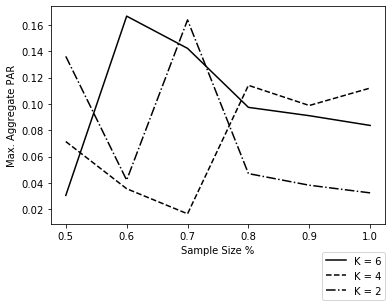

In [11]:
fig, ax = plt.subplots()

k2 = 6
sampleMaxMDataset = m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "-", label=f"K = {k2}", c="black")

k2 = 4
sampleMaxMDataset = m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "--", label=f"K = {k2}", c="black")

k2 = 2
sampleMaxMDataset = m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "-.", label=f"K = {k2}", c="black")

lgd = ax.legend(bbox_to_anchor=(1, -0.35), loc=4, borderaxespad=0.)
ax.set(xlabel='Sample Size %', ylabel='Max. Aggregate PAR',title='')
plt.show()
file_name = "peakpower_samplesize.pdf"
if file_name is not None:
    fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')


In [41]:
def show_summary(k, summary_treated, statistics):
    _list_clusters = {}
    _list_max_toal_m = {}
    for j in range(1, k+1):
        _list_clusters[j - 1] = str(summary_treated.query(f"sampleSize == 1.0 and k == {j}").sort_values(by=["s1. max m", "s1. agg m"]).iloc[0]["clusters"])
        _list_max_toal_m[j - 1] = str(float("{0:.6f}".format(summary_treated.query(f"sampleSize == 1.0 and k == {j}").sort_values(by=["s2. total m"]).iloc[0]["s2. total m"])))
    print(_list_clusters)
    a = statistics.query("sampleSize == 1.0 and metric == \"mean\"").reset_index().drop(["sampleSize", "metric"], axis=1)
    b = pd.DataFrame.from_dict(_list_clusters, orient="index", columns=["clusters"])
    c = pd.DataFrame.from_dict(_list_max_toal_m, orient="index", columns=["s2. total max m"])
    r = pd.concat([a,b,c], axis=1, sort=False)
    r = r[["k", "clusters", "s1. agg m", "s1. max m", "s1. peak", "s2. agg m", "s2. max m", "s2. peak", "s2. total m", "s2. total max m"]]
    return r

show_summary(exp1_k, exp1_treated, exp1_statistics)

{0: '[50]', 1: '[39, 11]', 2: '[19, 16, 15]', 3: '[17, 15, 11, 7]', 4: '[10, 12, 9, 10, 9]', 5: '[8, 8, 7, 9, 8, 10]'}


,k,clusters,s1. agg m,s1. max m,s1. peak,s2. agg m,s2. max m,s2. peak,s2. total m,s2. total max m
0,1,[50],1.965393,1.965393,1224.687000,1.842278,1.842278,1147.971000,1.842278,1.842278
1,2,"[39, 11]",1.007346,1.998230,813.958333,1.072307,2.242384,863.805333,1.842278,1.842278
2,3,"[19, 16, 15]",1.033244,2.183570,541.912333,1.100179,2.330778,538.794333,1.842278,1.842278
3,4,"[17, 15, 11, 7]",1.045735,2.218067,403.548000,1.225001,2.802740,537.514667,1.842278,1.842278
4,5,"[10, 12, 9, 10, 9]",1.055010,2.424548,369.271000,1.102880,2.636355,362.985667,1.842278,1.842278
5,6,"[8, 8, 7, 9, 8, 10]",1.065411,2.498804,358.435000,1.207207,2.946824,430.680333,1.842278,1.842278


In [29]:
get_metrics(exp1_k, "s1. agg m", "mean", exp1_statistics, exp1_sample_size_min, exp1_sample_size_max).iloc[-1]

1    1.965393
2    1.007346
3    1.033244
4    1.045735
5    1.055010
6    1.065411
Name: 1.0, dtype: float64

In [14]:
with open('summaryBatch.tex','w') as tf:
    tf.write(r.to_latex())

NameError: name 'r' is not defined